# Time-Series Forecasting


https://www.kaggle.com/datasets/shenba/time-series-datasets/?select=monthly-beer-production-in-austr.csv
Discuss the concept and application of Time series analysis using machine learning modelling by providing a real-world data set. What is the purpose of The Augmented Dickey-Fuller test in time series? a) Apply an appropriate Box-Jenkins model to the chosen dataset (ARMA, ARIMA, SARIMA etc). Check for the model adequacy. b) Make one-step-ahead forecasts of the last 10 observations. Determine the forecast errors. c) Make a time series plot of the data, and further calculate and illustrate the sample autocorrelation and partial autocorrelation (PA). Is there significant autocorrelation in the chosen time series?

In [206]:
##Importing necessary Libraries

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords
from itertools import chain
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud
import statistics
import sklearn.feature_extraction.text as sk_txt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
#Lets read in the data
df = pd.read_csv("monthly-beer-production-in-austr.csv")
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
#Summary of the Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [4]:
#converting the Month Object type to DateTime type for better Time series Analysis
df['Month']=pd.to_datetime(df['Month'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    476 non-null    datetime64[ns]
 1   Monthly beer production  476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


<Axes: xlabel='Month'>

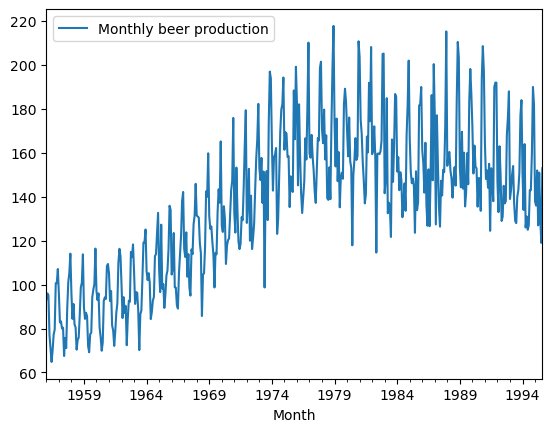

In [6]:
#view the Dataframe
df.plot(x="Month", y="Monthly beer production")

<Axes: >

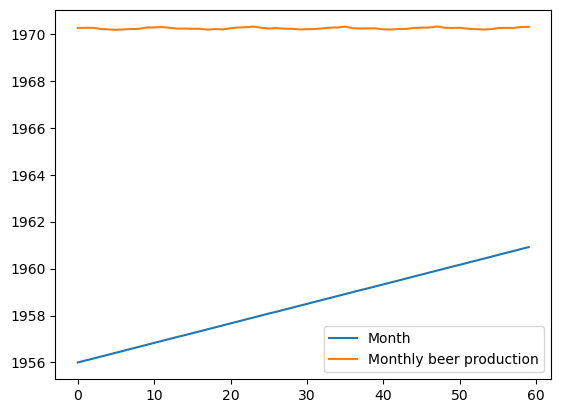

In [7]:
#closer look at first 50 observation for any trends and seasonality.
df.iloc[:60].plot()

In [8]:
# set the month column as the index
df.set_index('Month',inplace=True)

<Axes: xlabel='Month'>

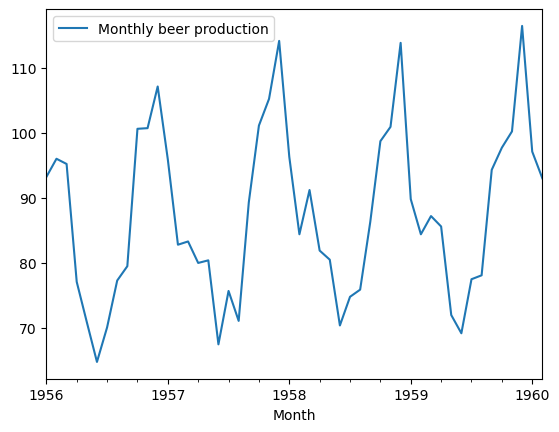

In [9]:
#closer look at first 50 observation for any trends and seasonality.
df.iloc[:50].plot()

 Observe that there is some annual seasonality

In [10]:

df.rename(columns = { "Monthly beer production": "Beer_Production"} , inplace=True)

In [11]:
df.head()

,Beer_Production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


<Figure size 640x480 with 0 Axes>

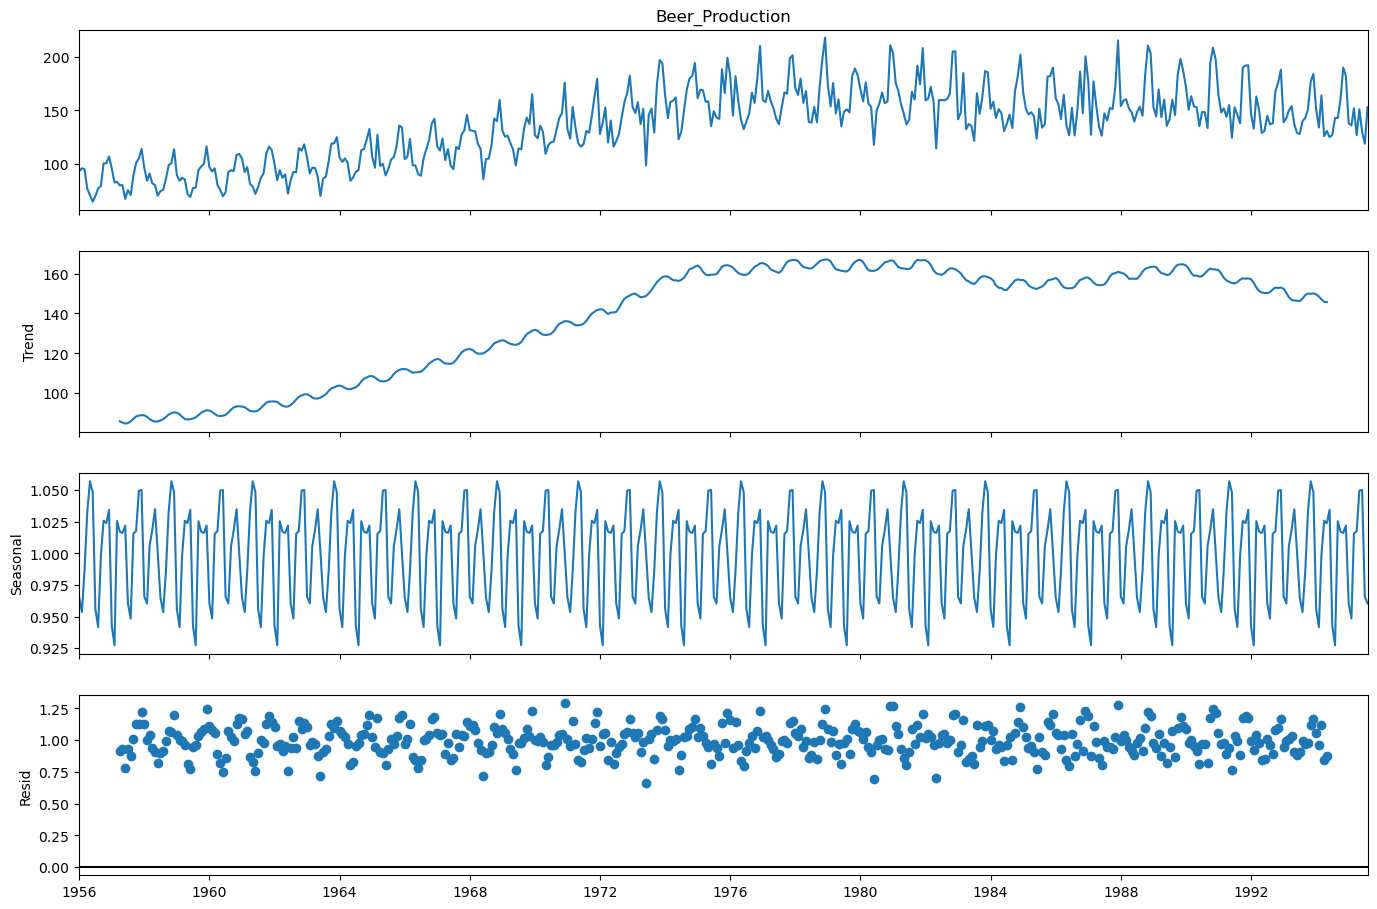

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["Beer_Production"], 
                            model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

let's use Dickey–Fuller test to test for stationarity.

In [13]:
adfuller(df["Beer_Production"])

(-2.282661418787579,
 0.17762099829132444,
 17,
 458,
 {'1%': -3.4447087976702284,
  '5%': -2.867871300049488,
  '10%': -2.5701423432047443},
 3463.9034375936567)

Running adfuller on the beer production column returns the following values in order : (ADF Test Statistic, p-value, No. of Lags Used, No. of Observations Used,{Critical Values},icbest)

The adfuller test returned a p-value of 0.178. We can assume that the data is stationary only if the p-value is very low (less than 0.05). 

In [14]:
df.shape

(476, 1)

To acheive stationarity, lets difference the production data by Difference with previous row and check the p-value using the adfuller test

In [15]:
adfuller(df["Beer_Production"].diff(1).dropna())

(-4.980663743064857,
 2.4234117859953556e-05,
 18,
 456,
 {'1%': -3.4447721346720885,
  '5%': -2.8678991615065095,
  '10%': -2.570157193174823},
 3455.355385768023)

To acheive stationarity, lets difference the production data by twelve months and check the p-value using the adfuller test

In [16]:
anYear_difference = df['Beer_Production'] - df['Beer_Production'].shift(12)


In [17]:
adfuller(anYear_difference.dropna())

(-2.896762477751989,
 0.04572577462359862,
 17,
 446,
 {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893},
 3363.9055003775306)

the p-value has reduced below 0.05 for 12 months difference. Hence we can assume stationarity when differencing by 12 months

In [18]:
df['anYear_difference']=anYear_difference

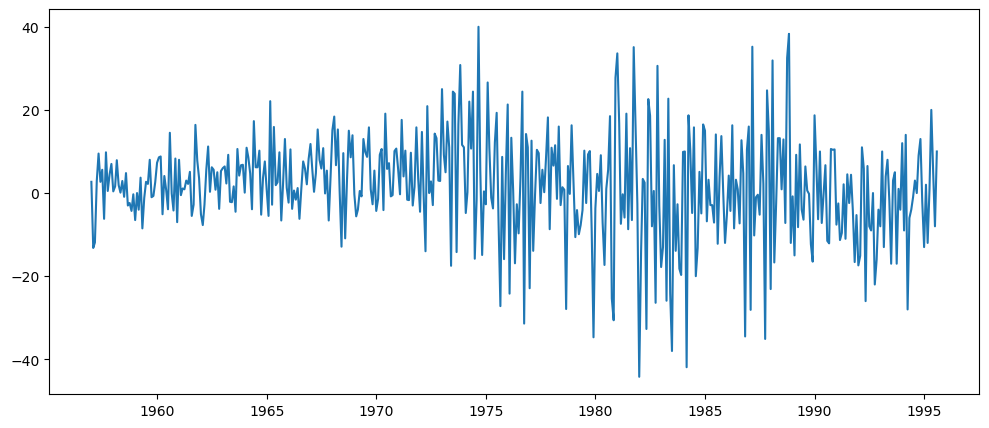

In [19]:
plt.figure(figsize= [12, 5])
plt.plot(df['anYear_difference']);

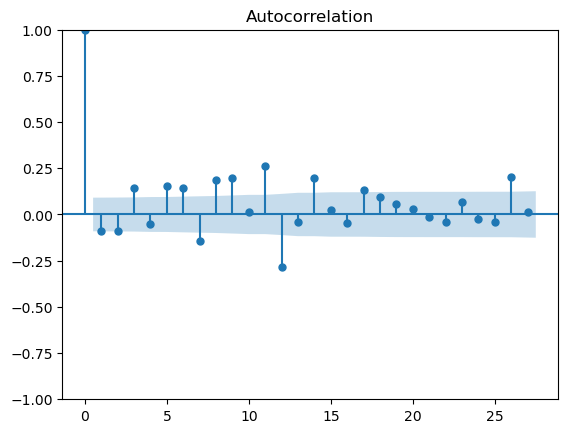

In [20]:
plot_acf(df['anYear_difference'].dropna());

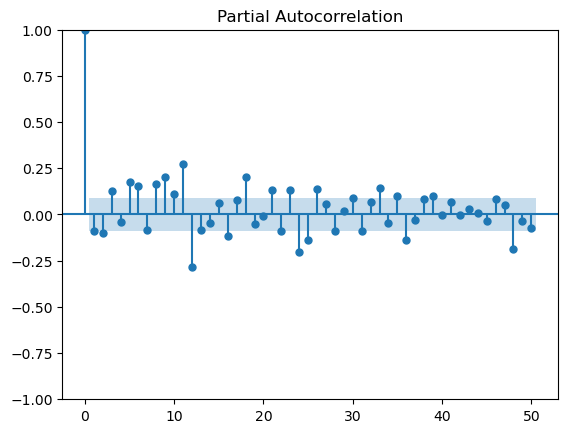

In [21]:
plot_pacf(df['anYear_difference'].dropna(), method="ywm", lags=50);

For an AR model, the theoretical PACF “shuts off” past the order(p) of the model
For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
Since our data is not an ideal case of the ARIMA model, the trend is not clearly visible. We will take p,d,q values as (1,1,1) and seasonal factor as 12 (for SARIMA model) To learn more on selecting p,d,q values from the autocorrelation charts

# Grid Search for ARIMA Model

In [52]:
aicVals2 = []
for p in range(4):
    for d in range(1, 4):
        for q in range(4):
            P=1
            D=1
            Q=1
#             for P in range(3):
#                 for D in range(1, 3):
#                     for Q in range(3):
            print(p, d, q, P, D, Q)
            aicVals2.append([SARIMAX(df["Beer_Production"], order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit().aic, p, d, q, P, D, Q]);

0 1 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06893D+00    |proj g|=  1.52734D-01

At iterate    5    f=  3.99789D+00    |proj g|=  1.10578D-02

At iterate   10    f=  3.99064D+00    |proj g|=  4.06148D-04

At iterate   15    f=  3.99062D+00    |proj g|=  9.99467D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   9.995D-07   3.991D+00
  F =   3.9906235229966058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 1 1 1 

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76810D+00    |proj g|=  1.03904D-01

At iterate    5    f=  3.65212D+00    |proj g|=  7.05903D-02


 This problem is unconstrained.



At iterate   10    f=  3.64431D+00    |proj g|=  6.83785D-03

At iterate   15    f=  3.64396D+00    |proj g|=  5.62350D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   5.624D-07   3.644D+00
  F =   3.6439568139845373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 1 2 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09529D+00    |proj g|=  6.93534D-01

At iterate    5    f=  3.68627D+00    |proj g|=  5.01143D-02

At iterate   10    f=  3.62883D+00    |proj g|=  3.29671D-02

At iterate   15    f=  3.62552D+00    |proj g|=  8.38148D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     18      1     0     0   2.430D-05   3.626D+00
  F =   3.6255214657578052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 1 3 1 

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73362D+00    |proj g|=  1.21731D-01

At iterate    5    f=  3.62636D+00    |proj g|=  7.08850D-02

At iterate   10    f=  3.60674D+00    |proj g|=  3.59925D-02

At iterate   15    f=  3.60397D+00    |proj g|=  8.66686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   1.658D-05   3.604D+00
  F =   3.6039726932856313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 2 0 1 

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60303D+00    |proj g|=  2.31631D-01

At iterate    5    f=  4.53377D+00    |proj g|=  1.02330D-02


 This problem is unconstrained.



At iterate   10    f=  4.50935D+00    |proj g|=  2.22177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   6.712D-06   4.509D+00
  F =   4.5093497043017532     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 2 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66536D+00    |proj g|=  9.77608D-01

At iterate    5    f=  4.09605D+00    |proj g|=  2.36378D-02

At iterate   10    f=  3.99531D+00    |proj g|=  3.33861D-03

At iterate   15    f=  3.99472D+00    |proj g|=  1.35323D-02

At iterate   20    f=  3.99444D+00    |proj g|=  5.46173D-03

At iterate   25    f=  3.99405D+00    |proj g|=  6.08946D-04

At iterate   30    f=  3.99399D+00    |proj g|=  5.57576D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83576D+00    |proj g|=  1.40162D+00

At iterate    5    f=  3.87000D+00    |proj g|=  3.44094D-02

At iterate   10    f=  3.66281D+00    |proj g|=  4.64074D-02

At iterate   15    f=  3.65740D+00    |proj g|=  2.47624D-03

At iterate   20    f=  3.65708D+00    |proj g|=  1.87601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   8.935D-06   3.657D+00
  F =   3.6570755122649898     

CONVERG

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76061D+00    |proj g|=  1.23286D+00


 This problem is unconstrained.



At iterate    5    f=  3.91680D+00    |proj g|=  5.55901D-02

At iterate   10    f=  3.68818D+00    |proj g|=  8.78787D-02

At iterate   15    f=  3.65225D+00    |proj g|=  9.02563D-03

At iterate   20    f=  3.64099D+00    |proj g|=  1.80916D-02

At iterate   25    f=  3.62892D+00    |proj g|=  5.79578D-03

At iterate   30    f=  3.62867D+00    |proj g|=  1.51692D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     39      1     0     0   1.000D-05   3.629D+00
  F =   3.6286662980690614     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 3 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22499D+00    |proj g|=  8.11404D-02

At iterate    5    f=  5.15517D+00    |proj g|=  1.36774D-01


 This problem is unconstrained.



At iterate   10    f=  5.09864D+00    |proj g|=  5.61240D-03

At iterate   15    f=  5.06561D+00    |proj g|=  2.77495D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   5.866D-06   5.066D+00
  F =   5.0655896868609451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 3 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40094D+00    |proj g|=  1.39935D+00

At iterate    5    f=  4.63472D+00    |proj g|=  1.30634D-02


 This problem is unconstrained.



At iterate   10    f=  4.51247D+00    |proj g|=  8.01980D-03

At iterate   15    f=  4.51235D+00    |proj g|=  2.79498D-03

At iterate   20    f=  4.51203D+00    |proj g|=  8.46008D-04

At iterate   25    f=  4.51199D+00    |proj g|=  2.27629D-04

At iterate   30    f=  4.51198D+00    |proj g|=  6.55778D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     46      1     0     0   3.033D-05   4.512D+00
  F =   4.5119848754861778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 3 2 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37315D+00    |proj g|=  3.62509D-02


 This problem is unconstrained.



At iterate    5    f=  4.15121D+00    |proj g|=  8.06974D-02

At iterate   10    f=  3.99739D+00    |proj g|=  3.65201D-04

At iterate   15    f=  3.99730D+00    |proj g|=  9.71124D-03

At iterate   20    f=  3.99703D+00    |proj g|=  2.93895D-04

At iterate   25    f=  3.99698D+00    |proj g|=  5.67463D-04

At iterate   30    f=  3.99601D+00    |proj g|=  2.34548D-03

At iterate   35    f=  3.99539D+00    |proj g|=  2.22225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     52      1     0     0   9.359D-06   3.995D+00
  F =   3.9953813638460849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75620D+00    |proj g|=  2.17937D+00

At iterate    5    f=  4.30689D+00    |proj g|=  3.32193D-02


 This problem is unconstrained.



At iterate   10    f=  3.80265D+00    |proj g|=  9.90978D-02

At iterate   15    f=  3.69480D+00    |proj g|=  1.80324D-02

At iterate   20    f=  3.66685D+00    |proj g|=  3.18100D-02

At iterate   25    f=  3.66415D+00    |proj g|=  1.66095D-03

At iterate   30    f=  3.66333D+00    |proj g|=  3.07805D-03

At iterate   35    f=  3.66140D+00    |proj g|=  4.02424D-03

At iterate   40    f=  3.66045D+00    |proj g|=  2.67644D-03

At iterate   45    f=  3.66037D+00    |proj g|=  2.02253D-03


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  3.66035D+00    |proj g|=  9.78585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78      1     0     0   9.786D-04   3.660D+00
  F =   3.6603509690457519     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
1 1 0 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94236D+00    |proj g|=  1.23580D-01

At iterate    5    f=  3.86578D+00    |proj g|=  6.68815D-02


 This problem is unconstrained.



At iterate   10    f=  3.85826D+00    |proj g|=  3.07628D-02

At iterate   15    f=  3.85624D+00    |proj g|=  2.25162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   3.696D-05   3.856D+00
  F =   3.8562336631427732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77004D+00    |proj g|=  1.18043D-01


 This problem is unconstrained.



At iterate    5    f=  3.65140D+00    |proj g|=  2.70892D-02

At iterate   10    f=  3.63403D+00    |proj g|=  6.14553D-03

At iterate   15    f=  3.63266D+00    |proj g|=  5.36853D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   2.168D-06   3.633D+00
  F =   3.6326571639714205     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92458D+00    |proj g|=  3.50764D-01

At iterate    5    f=  3.67309D+00    |proj g|=  3.55647D-02

At iterate   10    f=  3.64479D+00    |proj g|=  5.93777D-03

At iterate   15    f=  3.64167D+00    |proj g|=  4.73913D-03

At iterate   20    f=  3.64070D+00    |proj g|=  1.20220D-03

At iterate   25    f=  3.64067D+00    |proj g|=  8.25417D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     29      1     0     0   

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72431D+00    |proj g|=  1.49196D-01


 This problem is unconstrained.



At iterate    5    f=  3.64789D+00    |proj g|=  2.83187D-02

At iterate   10    f=  3.61318D+00    |proj g|=  8.21862D-03

At iterate   15    f=  3.60271D+00    |proj g|=  4.42771D-03

At iterate   20    f=  3.60189D+00    |proj g|=  6.86818D-03

At iterate   25    f=  3.60176D+00    |proj g|=  8.45275D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     28      1     0     0   8.453D-06   3.602D+00
  F =   3.6017631318718055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38283D+00    |proj g|=  2.14785D-01

At iterate    5    f=  4.31104D+00    |proj g|=  3.65085D-02


 This problem is unconstrained.



At iterate   10    f=  4.27989D+00    |proj g|=  4.75964D-04

At iterate   15    f=  4.27913D+00    |proj g|=  1.07808D-02

At iterate   20    f=  4.27822D+00    |proj g|=  5.34710D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   9.249D-06   4.278D+00
  F =   4.2782209741192254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06763D+00    |proj g|=  1.51144D-01

At iterate    5    f=  3.98206D+00    |proj g|=  7.29237D-02


 This problem is unconstrained.



At iterate   10    f=  3.87062D+00    |proj g|=  6.89339D-03

At iterate   15    f=  3.86631D+00    |proj g|=  4.12823D-02

At iterate   20    f=  3.86247D+00    |proj g|=  4.06264D-03

At iterate   25    f=  3.86068D+00    |proj g|=  9.15695D-04

At iterate   30    f=  3.86032D+00    |proj g|=  8.88602D-04

At iterate   35    f=  3.86029D+00    |proj g|=  4.38887D-04

At iterate   40    f=  3.86029D+00    |proj g|=  4.83972D-05

At iterate   45    f=  3.86029D+00    |proj g|=  1.09648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     51      1     0     0   1.096D-04   3.860D+00
  F =   3.86028531472

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50197D+00    |proj g|=  8.66082D-01


 This problem is unconstrained.



At iterate    5    f=  3.83014D+00    |proj g|=  3.58912D-02

At iterate   10    f=  3.67829D+00    |proj g|=  4.34546D-02

At iterate   15    f=  3.64069D+00    |proj g|=  5.06320D-02

At iterate   20    f=  3.63610D+00    |proj g|=  1.12849D-02

At iterate   25    f=  3.63441D+00    |proj g|=  4.28556D-03

At iterate   30    f=  3.63434D+00    |proj g|=  8.29620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   4.925D-06   3.634D+00
  F =   3.6343362385218576     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 3 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92145D+00    |proj g|=  1.35781D-01


 This problem is unconstrained.



At iterate    5    f=  3.79518D+00    |proj g|=  5.44180D-02

At iterate   10    f=  3.66040D+00    |proj g|=  8.52810D-02

At iterate   15    f=  3.64161D+00    |proj g|=  8.68914D-03

At iterate   20    f=  3.64113D+00    |proj g|=  5.66503D-04

At iterate   25    f=  3.64109D+00    |proj g|=  1.66834D-03

At iterate   30    f=  3.64106D+00    |proj g|=  5.72975D-04

At iterate   35    f=  3.64085D+00    |proj g|=  2.40127D-03

At iterate   40    f=  3.64054D+00    |proj g|=  1.58752D-03

At iterate   45    f=  3.64053D+00    |proj g|=  2.58472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     60   

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.92213D+00    |proj g|=  2.95449D-02

At iterate    5    f=  4.80972D+00    |proj g|=  3.35713D-02

At iterate   10    f=  4.76545D+00    |proj g|=  8.50903D-02

At iterate   15    f=  4.75919D+00    |proj g|=  3.61027D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   3.610D-06   4.759D+00
  F =   4.7591908226233608     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 3 1 1 

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09716D+00    |proj g|=  1.05149D+00

At iterate    5    f=  4.43425D+00    |proj g|=  6.96228D-02


 This problem is unconstrained.



At iterate   10    f=  4.29077D+00    |proj g|=  6.20156D-02

At iterate   15    f=  4.28460D+00    |proj g|=  1.75938D-04

At iterate   20    f=  4.28454D+00    |proj g|=  3.11891D-03

At iterate   25    f=  4.28431D+00    |proj g|=  1.42813D-03

At iterate   30    f=  4.28430D+00    |proj g|=  6.24988D-05

At iterate   35    f=  4.28429D+00    |proj g|=  3.28649D-03

At iterate   40    f=  4.28299D+00    |proj g|=  2.74387D-02

At iterate   45    f=  4.28200D+00    |proj g|=  1.77781D-03

At iterate   50    f=  4.28184D+00    |proj g|=  7.24993D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63   

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sari

1 3 2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31201D+00    |proj g|=  1.50341D+00

At iterate    5    f=  4.18599D+00    |proj g|=  2.65549D-02


 This problem is unconstrained.



At iterate   10    f=  3.87578D+00    |proj g|=  1.69862D-02

At iterate   15    f=  3.87377D+00    |proj g|=  1.70818D-04

At iterate   20    f=  3.87341D+00    |proj g|=  2.12390D-02
  ys=-4.996E-04  -gs= 1.724E-03 BFGS update SKIPPED

At iterate   25    f=  3.86582D+00    |proj g|=  5.09672D-03

At iterate   30    f=  3.86569D+00    |proj g|=  4.88826D-03

At iterate   35    f=  3.86494D+00    |proj g|=  6.25937D-03

At iterate   40    f=  3.86489D+00    |proj g|=  1.47509D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     69      1     1     0   7.190D-06   3.865D+00
  F =   3.8648923734491882     

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12776D+00    |proj g|=  1.13653D+00

At iterate    5    f=  4.29392D+00    |proj g|=  6.64687D-02


 This problem is unconstrained.



At iterate   10    f=  3.99709D+00    |proj g|=  9.52809D-03

At iterate   15    f=  3.99700D+00    |proj g|=  3.65452D-03

At iterate   20    f=  3.99670D+00    |proj g|=  2.52496D-04

At iterate   25    f=  3.99669D+00    |proj g|=  1.39692D-04

At iterate   30    f=  3.99575D+00    |proj g|=  1.58153D-02
  ys=-1.427E-03  -gs= 9.062E-05 BFGS update SKIPPED

At iterate   35    f=  3.99529D+00    |proj g|=  2.52374D-04

At iterate   40    f=  3.99527D+00    |proj g|=  7.56410D-04

At iterate   45    f=  3.99524D+00    |proj g|=  1.08167D-03


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  3.99522D+00    |proj g|=  7.29925D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     1     0   7.299D-04   3.995D+00
  F =   3.9952206576475935     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2 1 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78674D+00    |proj g|=  7.58383D-02

At iterate    5    f=  3.74149D+00    |proj g|=  3.80762D-02


 This problem is unconstrained.



At iterate   10    f=  3.72155D+00    |proj g|=  4.61883D-02

At iterate   15    f=  3.71375D+00    |proj g|=  3.46608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.079D-06   3.714D+00
  F =   3.7137382319089745     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75796D+00    |proj g|=  9.77426D-02

At iterate    5    f=  3.67074D+00    |proj g|=  3.14949D-02

At iterate   10    f=  3.61481D+00    |proj g|=  5.34351D-02

At iterate   15    f=  3.61116D+00    |proj g|=  4.47310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   1.592D-05   3.611D+00
  F =   3.6111432368390921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1 

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69199D+00    |proj g|=  1.14375D-01

At iterate    5    f=  3.62891D+00    |proj g|=  2.64799D-02

At iterate   10    f=  3.60586D+00    |proj g|=  2.32844D-02

At iterate   15    f=  3.60412D+00    |proj g|=  5.15925D-03

At iterate   20    f=  3.60405D+00    |proj g|=  3.30801D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     31      1     0     0   1.800D-05   3.604D+00
  F =   3.6040515477175874     

CONVERG

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82648D+00    |proj g|=  3.72745D-01


 This problem is unconstrained.



At iterate    5    f=  3.68488D+00    |proj g|=  2.48576D-01

At iterate   10    f=  3.62340D+00    |proj g|=  7.59354D-02

At iterate   15    f=  3.58834D+00    |proj g|=  3.51047D-02

At iterate   20    f=  3.57449D+00    |proj g|=  1.78574D-02

At iterate   25    f=  3.55917D+00    |proj g|=  5.18640D-02

At iterate   30    f=  3.55844D+00    |proj g|=  3.73980D-02

At iterate   35    f=  3.55169D+00    |proj g|=  7.98760D-02

At iterate   40    f=  3.54714D+00    |proj g|=  5.86933D-02

At iterate   45    f=  3.54599D+00    |proj g|=  5.91930D-02


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  3.54293D+00    |proj g|=  1.29908D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.299D-01   3.543D+00
  F =   3.5429299041775759     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2 2 0 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10528D+00    |proj g|=  1.52105D-01

At iterate    5    f=  4.06972D+00    |proj g|=  5.62757D-02


 This problem is unconstrained.



At iterate   10    f=  4.02972D+00    |proj g|=  1.22500D-02

At iterate   15    f=  4.02432D+00    |proj g|=  6.39603D-02

At iterate   20    f=  4.01818D+00    |proj g|=  4.46831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   4.978D-06   4.018D+00
  F =   4.0181845985266502     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 2 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01717D+00    |proj g|=  1.49922D-01

At iterate    5    f=  3.89363D+00    |proj g|=  1.14051D-01

At iterate   10    f=  3.72465D+00    |proj g|=  9.40832D-02

At iterate   15    f=  3.71900D+00    |proj g|=  6.24537D-03

At iterate   20    f=  3.71895D+00    |proj g|=  5.59154D-04

At iterate   25    f=  3.71880D+00    |proj g|=  5.38943D-03

At iterate   30    f=  3.71857D+00    |proj g|=  2.44505D-03

At iterate   35    f=  3.71854D+00    |proj g|=  3.96664D-04

At iterate   40    f=  3.71854D+00    |proj g|=  5.46047D-04

At iterate   45    f=  3.71854D+00    |proj g|=  6.35173D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14622D+00    |proj g|=  4.57627D-01


 This problem is unconstrained.



At iterate    5    f=  3.84806D+00    |proj g|=  5.83861D-02

At iterate   10    f=  3.69254D+00    |proj g|=  3.35423D-01

At iterate   15    f=  3.62641D+00    |proj g|=  9.03925D-03

At iterate   20    f=  3.62093D+00    |proj g|=  1.21250D-02

At iterate   25    f=  3.61850D+00    |proj g|=  7.09544D-03

At iterate   30    f=  3.61527D+00    |proj g|=  8.13314D-03

At iterate   35    f=  3.61492D+00    |proj g|=  2.17519D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     41      1     0     0   3.985D-05   3.615D+00
  F =   3.6149219833363269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12907D+00    |proj g|=  6.10530D-01


 This problem is unconstrained.



At iterate    5    f=  3.85081D+00    |proj g|=  5.06688D-02

At iterate   10    f=  3.68693D+00    |proj g|=  5.23967D-02

At iterate   15    f=  3.63703D+00    |proj g|=  1.54443D-02

At iterate   20    f=  3.62873D+00    |proj g|=  4.55903D-03

At iterate   25    f=  3.62807D+00    |proj g|=  1.95617D-03

At iterate   30    f=  3.62743D+00    |proj g|=  2.75454D-03

At iterate   35    f=  3.62352D+00    |proj g|=  4.58338D-02

At iterate   40    f=  3.61190D+00    |proj g|=  2.68852D-02

At iterate   45    f=  3.60839D+00    |proj g|=  5.67182D-03


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.60748D+00    |proj g|=  4.83408D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   4.834D-03   3.607D+00
  F =   3.6074779086308233     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2 3 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57000D+00    |proj g|=  1.38368D-01

At iterate    5    f=  4.47081D+00    |proj g|=  2.49083D-02


 This problem is unconstrained.



At iterate   10    f=  4.44365D+00    |proj g|=  3.77034D-02

At iterate   15    f=  4.42418D+00    |proj g|=  4.32608D-03

At iterate   20    f=  4.41181D+00    |proj g|=  6.09680D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     34      1     0     0   7.657D-07   4.412D+00
  F =   4.4117492009952963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 3 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38409D+00    |proj g|=  1.50130D-01

At iterate    5    f=  4.23944D+00    |proj g|=  2.87782D-02


 This problem is unconstrained.



At iterate   10    f=  4.07351D+00    |proj g|=  1.44440D-01

At iterate   15    f=  4.04380D+00    |proj g|=  1.72539D-03

At iterate   20    f=  4.04377D+00    |proj g|=  1.87271D-03
  ys=-7.789E-03  -gs= 8.369E-04 BFGS update SKIPPED

At iterate   25    f=  4.02624D+00    |proj g|=  2.74857D-02

At iterate   30    f=  4.02329D+00    |proj g|=  1.92178D-04

At iterate   35    f=  4.02327D+00    |proj g|=  1.65302D-03

At iterate   40    f=  4.02291D+00    |proj g|=  8.42291D-03

At iterate   45    f=  4.02280D+00    |proj g|=  2.18930D-03


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sari


At iterate   50    f=  4.02278D+00    |proj g|=  3.61177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     1     0   3.612D-04   4.023D+00
  F =   4.0227806418107566     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2 3 2 1 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74858D+00    |proj g|=  7.32080D-01

At iterate    5    f=  4.11406D+00    |proj g|=  1.17179D-01

At iterate   10    f=  3.96131D+00    |proj g|=  3.24861D-02

At iterate   15    f=  3.75014D+00    |proj g|=  5.94293D-02

At iterate   20    f=  3.74905D+00    |proj g|=  2.60175D-03

At iterate   25    f=  3.74880D+00    |proj g|=  3.13298D-03

At iterate   30    f=  3.74814D+00    |proj g|=  9.33059D-03

At iterate   35    f=  3.72937D+00    |proj g|=  8.36451D-03

At iterate   40    f=  3.72929D+00    |proj g|=  9.58079D-05

At iterate   45    f=  3.72929D+00    |proj g|=  4.67759D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75145D+00    |proj g|=  9.48500D-01

At iterate    5    f=  4.09677D+00    |proj g|=  8.13138D-02


 This problem is unconstrained.



At iterate   10    f=  3.96848D+00    |proj g|=  6.82578D-02

At iterate   15    f=  3.86925D+00    |proj g|=  1.69740D-02

At iterate   20    f=  3.86752D+00    |proj g|=  1.53202D-02

At iterate   25    f=  3.86536D+00    |proj g|=  1.27707D-02

At iterate   30    f=  3.85941D+00    |proj g|=  5.62388D-02

At iterate   35    f=  3.85352D+00    |proj g|=  1.49748D-02

At iterate   40    f=  3.81853D+00    |proj g|=  1.29408D-01

At iterate   45    f=  3.76271D+00    |proj g|=  6.40273D-02


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.67654D+00    |proj g|=  6.78411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     81      1     0     0   6.784D-02   3.677D+00
  F =   3.6765419594071753     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
3 1 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77772D+00    |proj g|=  9.47589D-02

At iterate    5    f=  3.73326D+00    |proj g|=  8.82048D-02


 This problem is unconstrained.



At iterate   10    f=  3.71375D+00    |proj g|=  8.74518D-03

At iterate   15    f=  3.70299D+00    |proj g|=  8.83355D-03

At iterate   20    f=  3.70285D+00    |proj g|=  6.15330D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   6.153D-07   3.703D+00
  F =   3.7028468331742133     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3 1 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75450D+00    |proj g|=  9.55452D-02


 This problem is unconstrained.



At iterate    5    f=  3.67627D+00    |proj g|=  1.07963D-01

At iterate   10    f=  3.63378D+00    |proj g|=  4.21074D-02

At iterate   15    f=  3.60981D+00    |proj g|=  1.04947D-02

At iterate   20    f=  3.60956D+00    |proj g|=  2.88767D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     25      1     0     0   9.900D-06   3.610D+00
  F =   3.6095551416569478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3 1 2 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92239D+00    |proj g|=  3.97593D-01


 This problem is unconstrained.



At iterate    5    f=  3.65626D+00    |proj g|=  2.91597D-02

At iterate   10    f=  3.60960D+00    |proj g|=  1.71984D-02

At iterate   15    f=  3.60408D+00    |proj g|=  2.58448D-03

At iterate   20    f=  3.60403D+00    |proj g|=  3.00455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   2.351D-05   3.604D+00
  F =   3.6040243889510193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 1 3 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69672D+00    |proj g|=  1.78080D-01


 This problem is unconstrained.



At iterate    5    f=  3.63948D+00    |proj g|=  3.79158D-02

At iterate   10    f=  3.60442D+00    |proj g|=  6.30424D-02

At iterate   15    f=  3.58815D+00    |proj g|=  2.42436D-01

At iterate   20    f=  3.56752D+00    |proj g|=  1.60714D-02

At iterate   25    f=  3.56133D+00    |proj g|=  3.34935D-02

At iterate   30    f=  3.56022D+00    |proj g|=  2.33833D-02

At iterate   35    f=  3.55712D+00    |proj g|=  2.61939D-02

At iterate   40    f=  3.55648D+00    |proj g|=  8.71105D-03

At iterate   45    f=  3.55487D+00    |proj g|=  2.44794D-02


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.55127D+00    |proj g|=  3.35708D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   3.357D-02   3.551D+00
  F =   3.5512723919342490     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
3 2 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05156D+00    |proj g|=  1.59658D-01


 This problem is unconstrained.



At iterate    5    f=  4.00646D+00    |proj g|=  4.54750D-02

At iterate   10    f=  3.97372D+00    |proj g|=  9.78102D-03

At iterate   15    f=  3.96505D+00    |proj g|=  4.08693D-02

At iterate   20    f=  3.96398D+00    |proj g|=  2.74394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     27      1     0     0   2.299D-05   3.964D+00
  F =   3.9639756258259706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 2 1 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00941D+00    |proj g|=  1.46270D-01

At iterate    5    f=  3.87994D+00    |proj g|=  5.30828D-02

At iterate   10    f=  3.71268D+00    |proj g|=  9.71920D-03

At iterate   15    f=  3.70918D+00    |proj g|=  2.45550D-02

At iterate   20    f=  3.70872D+00    |proj g|=  1.75150D-03

At iterate   25    f=  3.70843D+00    |proj g|=  1.30875D-02

At iterate   30    f=  3.70803D+00    |proj g|=  3.79923D-03

At iterate   35    f=  3.70797D+00    |proj g|=  8.41677D-04

At iterate   40    f=  3.70796D+00    |proj g|=  2.12079D-04

At iterate   45    f=  3.70796D+00    |proj g|=  1.41019D-04


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  3.70796D+00    |proj g|=  2.28086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   2.281D-04   3.708D+00
  F =   3.7079598245160854     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
3 2 2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.23697D+00    |proj g|=  5.57086D-01


 This problem is unconstrained.



At iterate    5    f=  3.78756D+00    |proj g|=  2.76719D-02

At iterate   10    f=  3.71835D+00    |proj g|=  3.15831D-03

At iterate   15    f=  3.71814D+00    |proj g|=  4.17933D-04

At iterate   20    f=  3.71811D+00    |proj g|=  2.14954D-03

At iterate   25    f=  3.71781D+00    |proj g|=  8.67560D-03

At iterate   30    f=  3.71774D+00    |proj g|=  6.91386D-04

At iterate   35    f=  3.71766D+00    |proj g|=  9.93981D-04

At iterate   40    f=  3.71715D+00    |proj g|=  5.81011D-03

At iterate   45    f=  3.71648D+00    |proj g|=  2.67593D-02


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  3.70825D+00    |proj g|=  1.21178D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   1.212D-01   3.708D+00
  F =   3.7082519309825854     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
3 2 3 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03586D+00    |proj g|=  2.70290D-01


 This problem is unconstrained.



At iterate    5    f=  3.81915D+00    |proj g|=  2.85967D-02

At iterate   10    f=  3.73870D+00    |proj g|=  4.30801D-02

At iterate   15    f=  3.68021D+00    |proj g|=  1.96862D-01

At iterate   20    f=  3.61998D+00    |proj g|=  1.92657D-02

At iterate   25    f=  3.61371D+00    |proj g|=  4.77851D-03

At iterate   30    f=  3.61266D+00    |proj g|=  4.05868D-04

At iterate   35    f=  3.61264D+00    |proj g|=  2.21884D-03

At iterate   40    f=  3.61263D+00    |proj g|=  3.54107D-04

At iterate   45    f=  3.61263D+00    |proj g|=  5.95832D-04


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.61262D+00    |proj g|=  8.74901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   8.749D-04   3.613D+00
  F =   3.6126160293493355     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
3 3 0 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44427D+00    |proj g|=  1.65503D-01

At iterate    5    f=  4.34607D+00    |proj g|=  1.51486D-02

At iterate   10    f=  4.31701D+00    |proj g|=  4.01368D-02

At iterate   15    f=  4.29188D+00    |proj g|=  5.98814D-02

At iterate   20    f=  4.28286D+00    |proj g|=  3.58639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   6.809D-06   4.283D+00
  F =   4.2828467849097915     

CONVERG

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38050D+00    |proj g|=  1.77185D-01

At iterate    5    f=  4.21186D+00    |proj g|=  5.09474D-02

At iterate   10    f=  4.02079D+00    |proj g|=  9.49560D-02

At iterate   15    f=  3.99125D+00    |proj g|=  4.71151D-03

At iterate   20    f=  3.99122D+00    |proj g|=  4.61866D-04

At iterate   25    f=  3.99101D+00    |proj g|=  9.29396D-03

At iterate   30    f=  3.97867D+00    |proj g|=  9.01443D-02
  ys=-3.487E-03  -gs= 1.127E-03 BFGS update SKIPPED

At iterate   35    f=  3.96926D+00    |proj g|=  1.59731D-03

At iterate   40    f=  3.96924D+00    |proj g|=  2.57572D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74790D+00    |proj g|=  1.18792D+00

At iterate    5    f=  4.07426D+00    |proj g|=  6.82004D-02


 This problem is unconstrained.



At iterate   10    f=  4.04992D+00    |proj g|=  5.12124D-02

At iterate   15    f=  4.01289D+00    |proj g|=  2.25638D-02

At iterate   20    f=  4.00994D+00    |proj g|=  2.25234D-02

At iterate   25    f=  4.00119D+00    |proj g|=  1.98292D-02

At iterate   30    f=  3.98433D+00    |proj g|=  2.44543D-01

At iterate   35    f=  3.88066D+00    |proj g|=  1.36588D-01

At iterate   40    f=  3.80820D+00    |proj g|=  4.29751D-02

At iterate   45    f=  3.75269D+00    |proj g|=  6.86852D-02


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  3.74758D+00    |proj g|=  1.04705D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.047D-02   3.748D+00
  F =   3.7475842854090944     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
3 3 3 1 1 1


/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51389D+00    |proj g|=  4.28927D-01


 This problem is unconstrained.



At iterate    5    f=  4.01362D+00    |proj g|=  3.17915D-02

At iterate   10    f=  3.78643D+00    |proj g|=  1.28793D-01

At iterate   15    f=  3.75415D+00    |proj g|=  2.69838D-03

At iterate   20    f=  3.75411D+00    |proj g|=  4.82657D-03
  ys=-1.399E-04  -gs= 3.519E-03 BFGS update SKIPPED

At iterate   25    f=  3.74615D+00    |proj g|=  3.87395D-02

At iterate   30    f=  3.74432D+00    |proj g|=  1.77994D-03

At iterate   35    f=  3.73692D+00    |proj g|=  4.22504D-02

At iterate   40    f=  3.72666D+00    |proj g|=  4.17959D-03

At iterate   45    f=  3.72665D+00    |proj g|=  3.97457D-04

At iterate   50    f=  3.72664D+00    |proj g|=  1.41924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Sorting the values--210111,220111,230111,

In [24]:

aicVals2.sort()

In [25]:
aicVals2

[[3388.869268777052, 2, 1, 3, 1, 1, 1],
 [3398.811317121405, 3, 1, 3, 1, 1, 1],
 [3442.878501541959, 1, 1, 3, 1, 1, 1],
 [3442.982004007921, 0, 1, 3, 1, 1, 1],
 [3445.057073427143, 2, 1, 2, 1, 1, 1],
 [3447.0312182813705, 3, 1, 2, 1, 1, 1],
 [3449.8083614708157, 2, 1, 1, 1, 1, 1],
 [3450.2964948574145, 3, 1, 1, 1, 1, 1],
 [3450.3189690165436, 2, 2, 3, 1, 1, 1],
 [3455.4057281361834, 2, 2, 2, 1, 1, 1],
 [3457.2104599405675, 3, 2, 3, 1, 1, 1],
 [3461.4964354014305, 0, 1, 2, 1, 1, 1],
 [3466.4903157617464, 0, 2, 3, 1, 1, 1],
 [3468.2896201007925, 1, 1, 1, 1, 1, 1],
 [3471.8880990728085, 1, 2, 2, 1, 1, 1],
 [3477.0468869132796, 0, 1, 1, 1, 1, 1],
 [3477.922493263315, 1, 1, 2, 1, 1, 1],
 [3479.7841055482304, 1, 2, 3, 1, 1, 1],
 [3491.5358876762702, 0, 2, 2, 1, 1, 1],
 [3496.654122531556, 0, 3, 3, 1, 1, 1],
 [3516.067945355631, 2, 3, 3, 1, 1, 1],
 [3537.110185181851, 3, 1, 0, 1, 1, 1],
 [3543.977752939313, 3, 2, 1, 1, 1, 1],
 [3545.4787967773436, 2, 1, 0, 1, 1, 1],
 [3546.255838295421, 3, 2,

# Model building

Split the dataframe to 80 :20 for Modelling

In [26]:
df.shape

(476, 2)

In [27]:
df.tail()

,Beer_Production,anYear_difference
Month,,
1995-04-01,127.0,1.0
1995-05-01,151.0,20.0
1995-06-01,130.0,5.0
1995-07-01,119.0,-8.0
1995-08-01,153.0,10.0


In [28]:
split = int(df.shape[0] * 0.8)
split

380

In [29]:
df_train = df[:split]
df_test = df[split:]

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380 entries, 1956-01-01 to 1987-08-01
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Beer_Production    380 non-null    float64
 1   anYear_difference  368 non-null    float64
dtypes: float64(2)
memory usage: 8.9 KB


 ARIMA  model does not account for seasonality. So lets implement Seasonal ARIMA model.

In [53]:
model = SARIMAX(df["Beer_Production"], order=(2, 1, 3), seasonal_order=(1, 1, 1,12))
results=model.fit()

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82648D+00    |proj g|=  3.72745D-01


 This problem is unconstrained.



At iterate    5    f=  3.68488D+00    |proj g|=  2.48576D-01

At iterate   10    f=  3.62340D+00    |proj g|=  7.59354D-02

At iterate   15    f=  3.58834D+00    |proj g|=  3.51047D-02

At iterate   20    f=  3.57449D+00    |proj g|=  1.78574D-02

At iterate   25    f=  3.55917D+00    |proj g|=  5.18640D-02

At iterate   30    f=  3.55844D+00    |proj g|=  3.73980D-02

At iterate   35    f=  3.55169D+00    |proj g|=  7.98760D-02

At iterate   40    f=  3.54714D+00    |proj g|=  5.86933D-02

At iterate   45    f=  3.54599D+00    |proj g|=  5.91930D-02

At iterate   50    f=  3.54293D+00    |proj g|=  1.29908D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Month'>

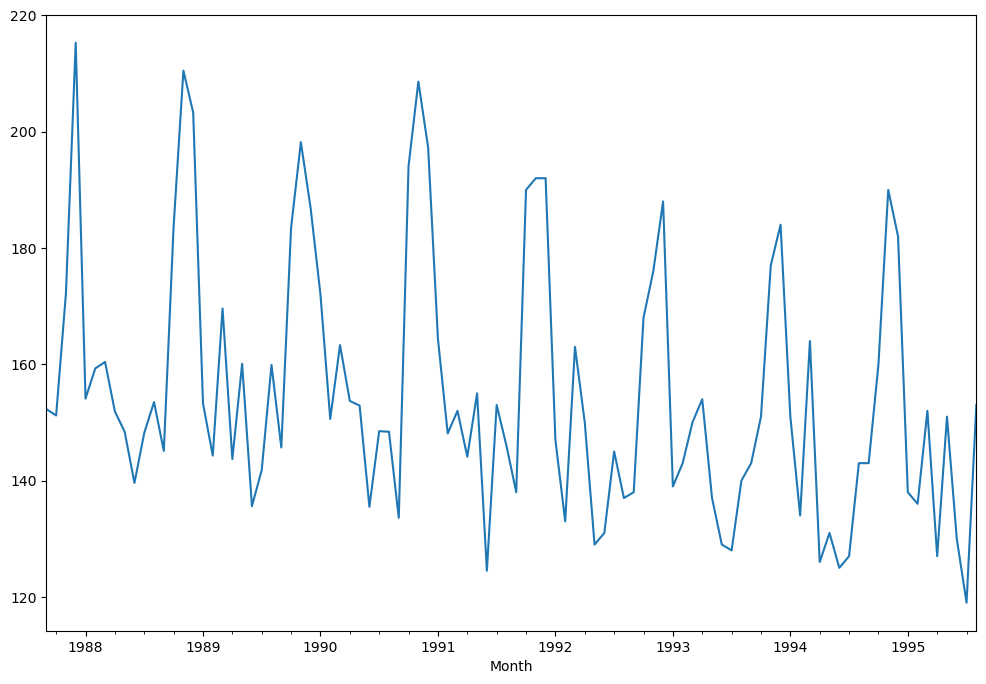

In [54]:
df['SARIMA forecast1']=results.predict(start=380,end=476,dynamic=True)

df_test['Beer_Production'].plot(figsize=(12,8))


<Axes: xlabel='Month'>

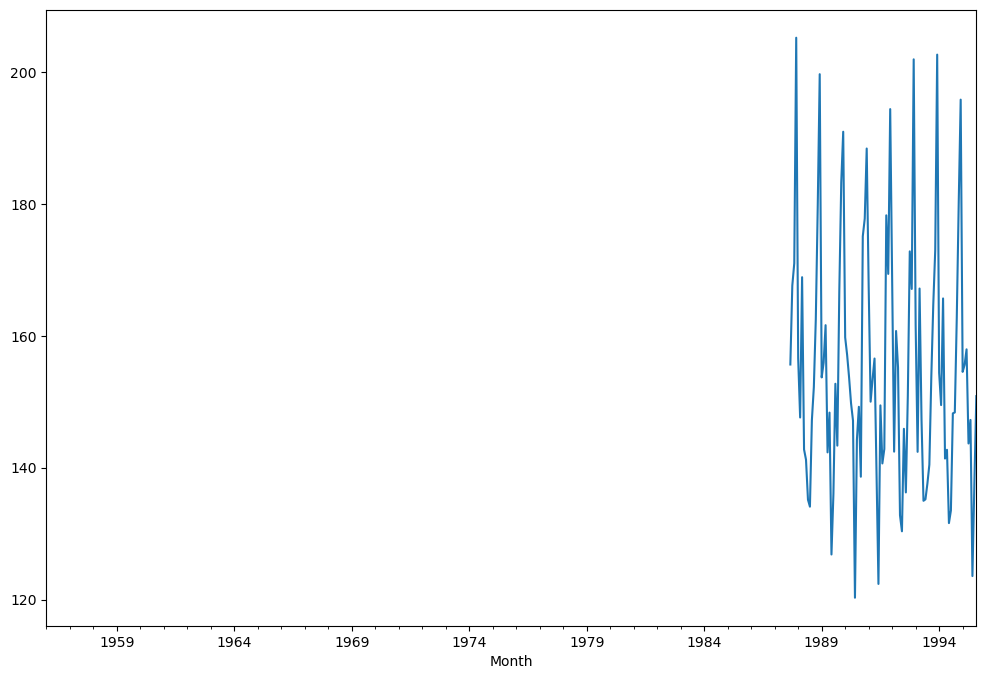

In [55]:
df['SARIMA forecast1'].plot(figsize=(12,8))

<Axes: xlabel='Month'>

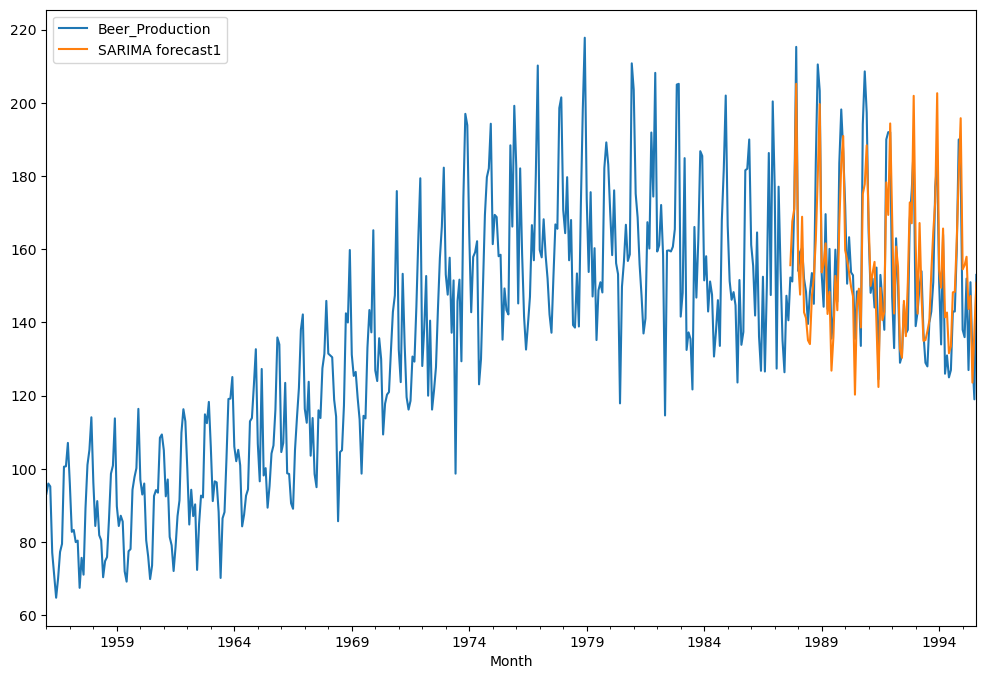

In [56]:
df[['Beer_Production','SARIMA forecast1']].plot(figsize=(12,8))

In [57]:
residuals1=df['Beer_Production']-df['SARIMA forecast1']
residuals1.dropna(inplace=True)

<Axes: xlabel='Month'>

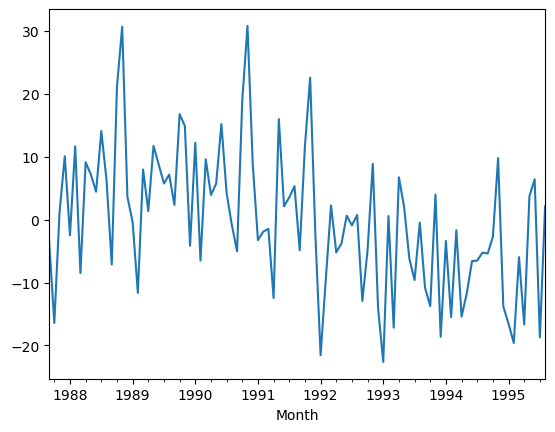

In [58]:
residuals1.plot()

r2_score(df["SARIMA forecast1"], df["Beer_Production"])

In [59]:
df_test.head

<bound method NDFrame.head of             Beer_Production  anYear_difference
Month                                         
1987-09-01            152.3                2.2
1987-10-01            151.2              -35.1
1987-11-01            172.2               24.7
1987-12-01            215.3               14.9
1988-01-01            154.1              -23.1
...                     ...                ...
1995-04-01            127.0                1.0
1995-05-01            151.0               20.0
1995-06-01            130.0                5.0
1995-07-01            119.0               -8.0
1995-08-01            153.0               10.0

[96 rows x 2 columns]>

In [60]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals1/df['Beer_Production'].iloc[380:476])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals1**2)))

Mean Absolute Percent Error: 0.0565
Root Mean Squared Error: 11.083264395469888


Model2

In [38]:
model2=SARIMAX(df_train["Beer_Production"],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results2=model2.fit()

/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/parvind/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74126D+00    |proj g|=  1.31055D-01

At iterate    5    f=  3.63085D+00    |proj g|=  3.80065D-02

At iterate   10    f=  3.60677D+00    |proj g|=  2.63743D-03

At iterate   15    f=  3.60389D+00    |proj g|=  3.48446D-02

At iterate   20    f=  3.60285D+00    |proj g|=  1.95721D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   1.470D-05   3.603D+00
  F =   3.6028493190013928     

CONVERG

<Axes: xlabel='Month'>

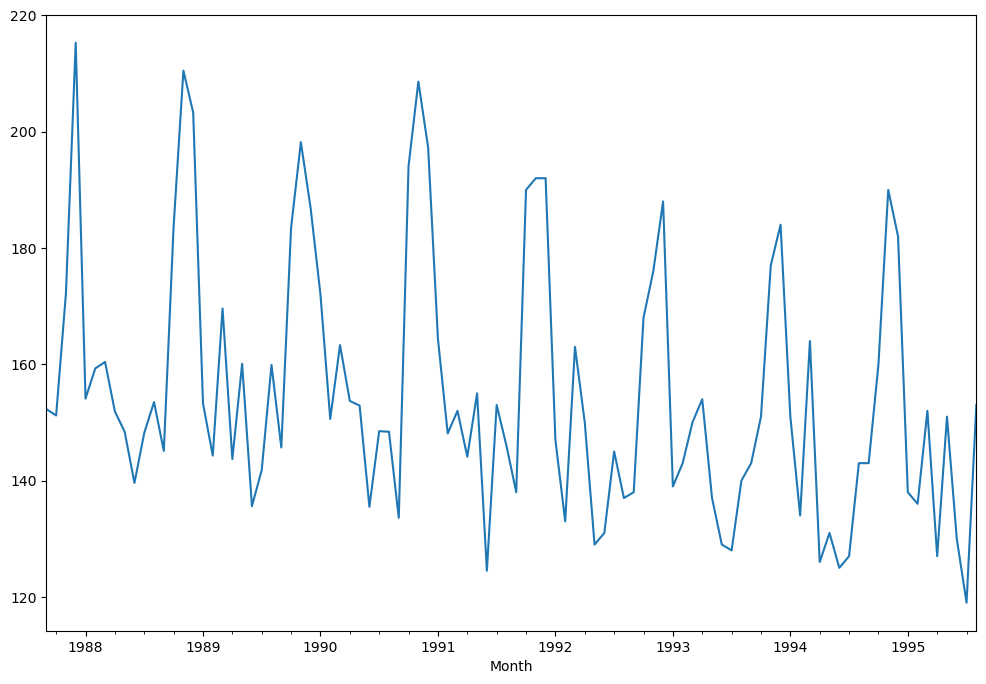

In [39]:
df['SARIMA forecast']=results2.predict(start=380,end=476,dynamic=True)

df_test['Beer_Production'].plot(figsize=(12,8))

<Axes: xlabel='Month'>

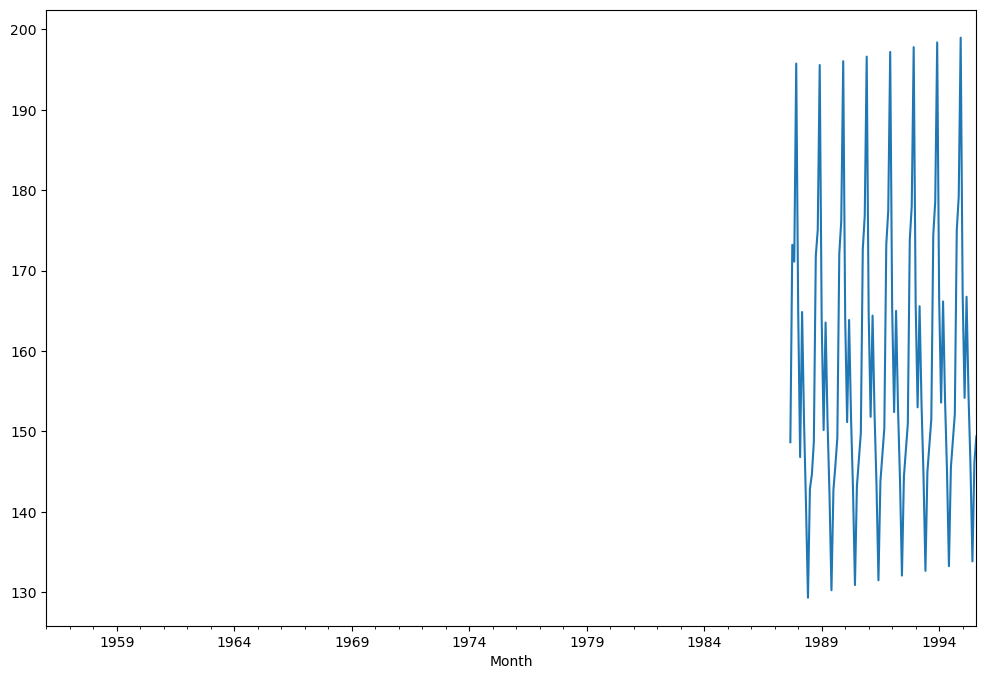

In [40]:
df['SARIMA forecast'].plot(figsize=(12,8))

<Axes: xlabel='Month'>

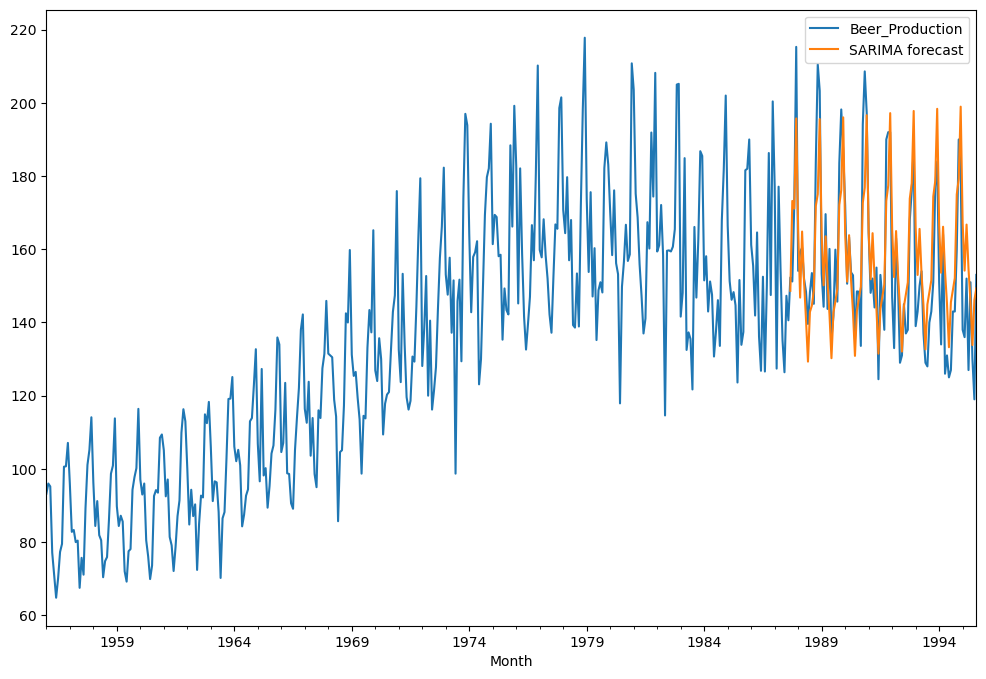

In [41]:
df[['Beer_Production','SARIMA forecast']].plot(figsize=(12,8))

<Axes: xlabel='Month'>

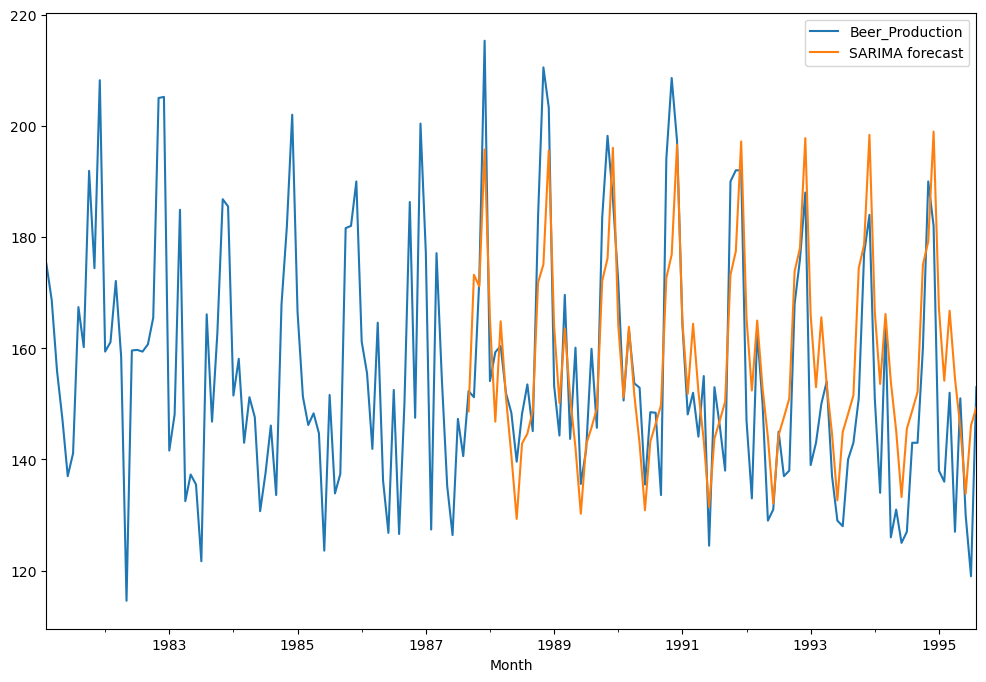

In [42]:
df[['Beer_Production','SARIMA forecast']].iloc[301:476].plot(figsize=(12,8))

From visual analysis, we can see that the SARIMA model performed reasonably well. However, to understand the accuracy of the model mathematically, we can calculate the residual and find the mean absolute percent error and root mean squared error.

In [43]:
residuals=df['Beer_Production']-df['SARIMA forecast']
residuals.dropna(inplace=True)

<Axes: xlabel='Month'>

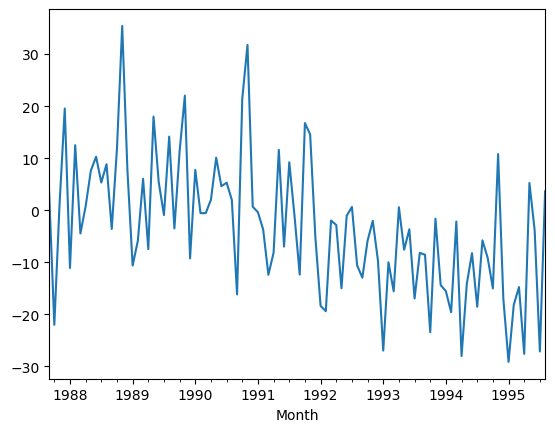

In [44]:
residuals.plot()

In [45]:
df_test.head()

,Beer_Production,anYear_difference
Month,,
1987-09-01,152.3,2.2
1987-10-01,151.2,-35.1
1987-11-01,172.2,24.7
1987-12-01,215.3,14.9
1988-01-01,154.1,-23.1


In [46]:
df["SARIMA forecast"].head()

Month
1956-01-01   NaN
1956-02-01   NaN
1956-03-01   NaN
1956-04-01   NaN
1956-05-01   NaN
Name: SARIMA forecast, dtype: float64

In [50]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/df['Beer_Production'].iloc[380:476])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0695
Root Mean Squared Error: 13.292857041679921


Now, lets forecast values for the next 10 observations /next 10 months 

In [67]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,10)]

In [68]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)


In [69]:
future_df=pd.concat([df,future_datest_df])

<Axes: >

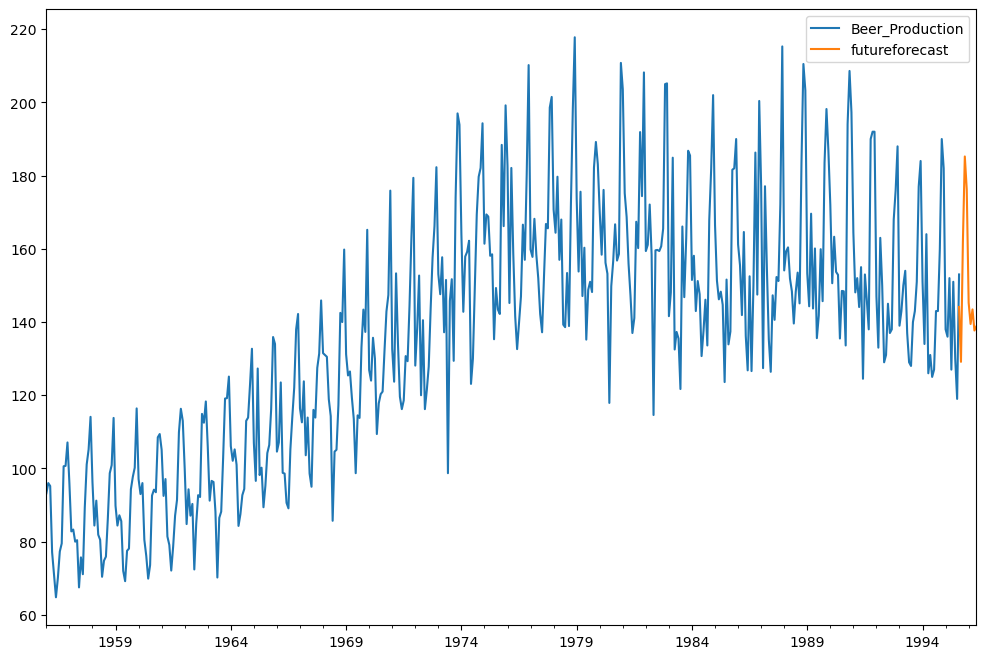

In [71]:
future_df['futureforecast'] = results.predict(start = 475, end = 486, dynamic= True)  
future_df[['Beer_Production', 'futureforecast']].plot(figsize=(12, 8))

<Axes: >

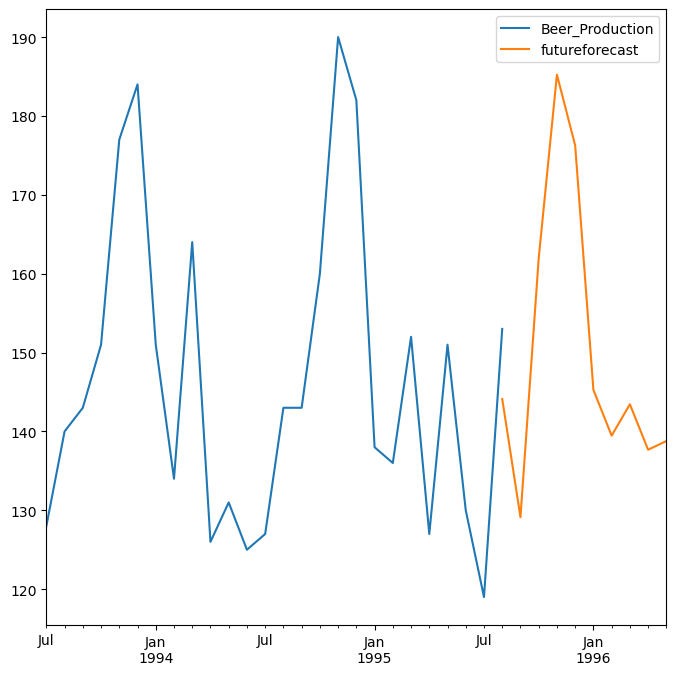

In [72]:
future_df[['Beer_Production', 'futureforecast']].iloc[450:].plot(figsize=(8, 8))

Conclusion:

# Discuss the concept and application of Text Analytics (eg text categorisation, topic modelling and document summarisation) using machine learning modelling by providing a real-world data set of social media posts. 
Apply appropriate text analytics tools to the chosen dataset. 

In [73]:
!pip install praw

  Obtaining dependency information for praw from https://files.pythonhosted.org/packages/81/6a/21bc058bcccbe03f6a0895bf1bd60c805f0c526aa4e9bfaac775ed0b299c/praw-7.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for prawcore<3,>=2.1 from https://files.pythonhosted.org/packages/96/5c/8af904314e42d5401afcfaff69940dc448e974f80f7aa39b241a4fbf0cf1/prawcore-2.4.0-py3-none-any.whl.metadata
  Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)
Using cached praw-7.7.1-py3-none-any.whl (191 kB)
Using cached prawcore-2.4.0-py3-none-any.whl (17 kB)


In [86]:
import praw
import pandas as pd
from datetime import datetime as dt

In [87]:
reddit = praw.Reddit(
    client_id="DXnqjzAYbre6OvEpvOsyMw", # Right below 'personal use script'
    client_secret="L-DlslXlKnI1-x10fuxFaywIhSlXSw", # secret
    user_agent="mlb-2023 u/SeaworthinessUsed876", # app-name u/username
)
"SeaworthinessUsed876"

'SeaworthinessUsed876'

In [88]:
print(reddit.read_only)

True


In [95]:
subreddit = reddit.subreddit("jobs")

In [96]:
print(subreddit.display_name)
# If the api is not connected, the following will give a 401 error
print(subreddit.title)
print(subreddit.description)

jobs
Jobs
#####  

Welcome to /r/jobs!  

Please make sure to set flair for your posts to facilitate categorization.

Please read the [FAQ](http://www.reddit.com/r/jobs/comments/2jydy3/the_most_repetitive_questions_on_rjobs/) before posting.

Check out our discord here: https://discord.gg/TY6ErXV

### Rules

* (1) No Job Posts, No Self Promotion. This community is not a jobs board. 
No Job Posts or Self Promotion of any kind. Posts and/or comments of any "job boards", "job listings", "recruiters", "services", "ads" - regardless of "free" or "paid" are not allowed.  If you want to advertise, please [ buy an ad ](https://www.reddit.com/advertising/).  

* (2) General Conduct - This is a professional, family friendly sub - Foul Language is not welcome. Please keep discussions civil.  No posts or comments making personal attacks or wishing harm to others or themselves.  

* (3) Please be specific with your post title.  Refrain from using vague titles such as "I need help" and similar.  

*

In [97]:
for post in subreddit.new(limit=10):
    print("***************")
    print(post.title)
    for comment in list(post.comments):
        print(comment.body)
        print(comment.created_utc)
        print(dt.fromtimestamp(comment.created_utc))
        print("---------")
#     print("in the indent")
# print("outside the indent")

***************
Is a Professional Career Counselor Worth it?
***************
Need help finding a career path
***************
For tech jobs - Software Architecture - Beginner's guide on choosing right Database - SQL vs NoSQL
Report for link farming. Dude wants views for his channel, obviously. And to be quite honest, I don't think you're at the level of seniority such that you should be teaching others.
1700906065.0
2023-11-25 09:54:25
---------
***************
where is the money going?
i figured it out, my tips were getting decucted from the overall pay
1700906674.0
2023-11-25 10:04:34
---------
***************
I quit my job and my piece of shit boss.
It's kind of useless giving them all of your thought process.

I've been 'wronged' and treated as a lesser citizen by people, none of them made it to the level I am at today, even the most condescending douchebag ever.
1700904745.0
2023-11-25 09:32:25
---------
***************
FTTT NOC L1 job
***************
Post From Former Workplace
Dis

In [106]:
postTitles = []
postTimes = []
for post in subreddit.new(limit=50):
    postTitles.append(post.title)
    postTimes.append(dt.fromtimestamp(post.created_utc))

In [107]:
df4 = pd.DataFrame({
    "Post Title": postTitles,
    "Post Time" : postTimes
})

In [108]:
df4.head()

,Post Title,Post Time
0,Keeping internship/university experience on re...,2023-11-25 15:29:09
1,Non-IT Job market in New Zealand?,2023-11-25 15:23:57
2,Overwhelmed with emotion upon receiving a sign...,2023-11-25 14:56:20
3,Am I making a huge mistake?,2023-11-25 14:45:08
4,Tips for websites that offer remote work inter...,2023-11-25 14:22:06


In [154]:
df4.to_csv("Reddit Python Posts.csv", index=False)

In [155]:
df5 = pd.read_csv("Reddit Python Posts.csv")

In [156]:
df5.head()

,Post Title,Post Time
0,Keeping internship/university experience on re...,2023-11-25 15:29:09
1,Non-IT Job market in New Zealand?,2023-11-25 15:23:57
2,Overwhelmed with emotion upon receiving a sign...,2023-11-25 14:56:20
3,Am I making a huge mistake?,2023-11-25 14:45:08
4,Tips for websites that offer remote work inter...,2023-11-25 14:22:06


In [157]:
df5.shape

(50, 2)

In [158]:
sia = SentimentIntensityAnalyzer()

In [159]:
def compound_score(post):
    scores = [sia.polarity_scores(sentence)["compound"]  for sentence in nltk.sent_tokenize(post)]
    if (len(scores) >= 1):
        return statistics.mean(scores)
    else:
        return np.nan

In [160]:
print(df5["Post Title"][0])


Keeping internship/university experience on resume at 23?


In [161]:
compound_score(df5["Post Title"][0])

0.0

In [162]:
df5["Compound Score"] = [compound_score(post) for post in df5["Post Title"]]

In [163]:
df5[ df5["Compound Score"].isnull() ]

,Post Title,Post Time,Compound Score


In [164]:
for row in df5.sort_values("Compound Score", ascending=True).iloc[:3, 0]:
    print(row)
    print("***************************")

Student placements are so freaking hard to find!
***************************
I quit my job and my piece of shit boss.
***************************
AC at work has been broken for a year + some (FL)
***************************


In [165]:
df5.head()

,Post Title,Post Time,Compound Score
0,Keeping internship/university experience on re...,2023-11-25 15:29:09,0.0000
1,Non-IT Job market in New Zealand?,2023-11-25 15:23:57,0.0000
2,Overwhelmed with emotion upon receiving a sign...,2023-11-25 14:56:20,0.5106
3,Am I making a huge mistake?,2023-11-25 14:45:08,-0.0258
4,Tips for websites that offer remote work inter...,2023-11-25 14:22:06,0.0000


In [166]:
THRESHOLD = 0.1

conditions = [
    (df5['Compound Score'] <= -THRESHOLD),
    (df5['Compound Score'] > -THRESHOLD) & (df5['Compound Score'] < THRESHOLD),
    (df5['Compound Score'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
df5['label'] = np.select(conditions, values)

df5.head()

,Post Title,Post Time,Compound Score,label
0,Keeping internship/university experience on re...,2023-11-25 15:29:09,0.0000,neu
1,Non-IT Job market in New Zealand?,2023-11-25 15:23:57,0.0000,neu
2,Overwhelmed with emotion upon receiving a sign...,2023-11-25 14:56:20,0.5106,pos
3,Am I making a huge mistake?,2023-11-25 14:45:08,-0.0258,neu
4,Tips for websites that offer remote work inter...,2023-11-25 14:22:06,0.0000,neu


In [167]:
sentence0 = df5['Post Title'].iloc[2]
print(sentence0)
words0 = df5['Post Title'].iloc[2].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0:
  if (sia.polarity_scores(word)['compound']) >= THRESHOLD:
    pos_list.append(word)
  elif (sia.polarity_scores(word)['compound']) <= -THRESHOLD:
    neg_list.append(word)
  else:
    neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sia.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")
print(f"The compound value : {score['compound']} >= {-THRESHOLD}")
print(f"\nThis sentence is POSITIVE")

Overwhelmed with emotion upon receiving a significant income increase.
['Overwhelmed', 'with', 'emotion', 'upon', 'receiving', 'a', 'significant', 'income', 'increase.']

Positive: ['significant', 'increase.']
Neutral: ['Overwhelmed', 'with', 'emotion', 'upon', 'receiving', 'a', 'income']
Negative: []

This sentence is 0.0% negative
This sentence is 48.5% neutral
This sentence is 51.5% positive
The compound value : 0.5106 >= -0.1

This sentence is POSITIVE


In [168]:
df5['label'].value_counts()

neu    30
pos    13
neg     7
Name: label, dtype: int64

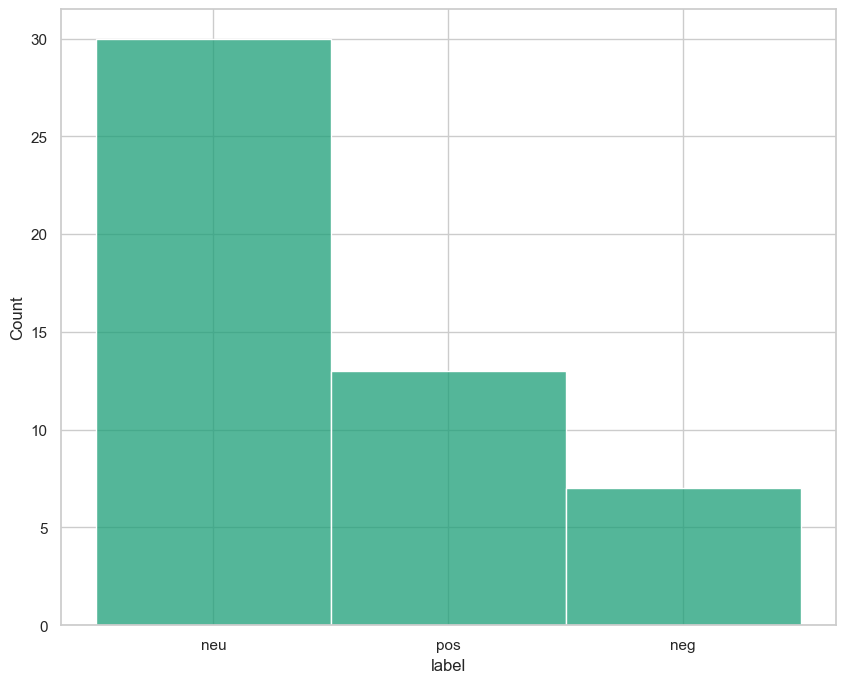

In [169]:
sns.histplot(df5['label']);

Are the labels accurate?

In [170]:
def news_title_output(df_temp, label):
  res = df_temp[df_temp['label'] == label]['Post Title'].values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
news_sub = df5.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
news_title_output(news_sub, "pos")

print("\nNeutral news")
news_title_output(news_sub, "neu")

print("\nNegative news")
news_title_output(news_sub, "neg")

Positive news
Do you guys send a thank you email after an interview? And what do you say?
Great jobs for lazy people?
Thank you so much everyone
Need help finding a career path
Red Flag in a job offer . Pondering to accept the offer or look for something else?

Neutral news
finding a new job, full time college student
Am I making a huge mistake?
Any job suggestions for a school leaver?
Non-IT Job market in New Zealand?
Need advice

Negative news
I quit my job and my piece of shit boss.
How do I get my first job without experience or friends?
AC at work has been broken for a year + some (FL)
I found out the job I got was limited service. What can I expect?
I shouldn’t be complaining right?


In [172]:
stop_words = stopwords.words('english')


179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [175]:
# Join all the text into one long string for the word cloud
long_string = ','.join(df5['Post Title'])
len(long_string)

2399

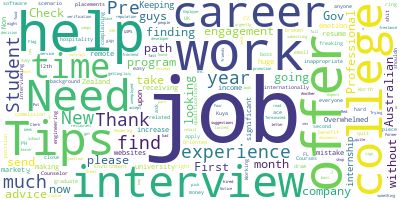

In [176]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [177]:
# Adding more stop words based on 'expert knowledge' and some data exploration
stop_words.extend(['Pre', 'guys', 'help', 'job', 'work', 'Need','Tips'])

In [178]:
print(len(stop_words))
print(stop_words[:10])

192
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [183]:


def custom_tokenize(text):
  # remove single quote and dashes

    text = text.replace("'", "").replace(".", "").replace("-", "").replace("?", "").replace("!", "").lower()
    
  # split on words only
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tk.tokenize(text)

  # remove stop words
    words = [w for w in tokens if not w in stop_words]
    return words



In [186]:
def tokens_2_words(df_temp, label):
  # subset titles based on label
  titles = df_temp[df_temp['label'] == label]['Post Title']
  # apply our custom tokenize function to each title
  tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
  words = list(chain.from_iterable(tokens))
  return words

pos_words = tokens_2_words(df5, 'pos')
neg_words = tokens_2_words(df5, 'neg')

In [187]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('thank', 2),
 ('interview', 2),
 ('get', 2),
 ('career', 2),
 ('need', 2),
 ('please', 2),
 ('offer', 2),
 ('overwhelmed', 1),
 ('emotion', 1),
 ('upon', 1),
 ('receiving', 1),
 ('significant', 1),
 ('income', 1),
 ('increase', 1),
 ('much', 1),
 ('everyone', 1),
 ('send', 1),
 ('email', 1),
 ('say', 1),
 ('easy', 1)]

In [188]:
neg_freq = nltk.FreqDist(neg_words)
neg_freq.most_common(20)

[('first', 2),
 ('ac', 1),
 ('broken', 1),
 ('year', 1),
 ('fl', 1),
 ('student', 1),
 ('placements', 1),
 ('freaking', 1),
 ('hard', 1),
 ('find', 1),
 ('quit', 1),
 ('piece', 1),
 ('shit', 1),
 ('boss', 1),
 ('complaining', 1),
 ('right', 1),
 ('might', 1),
 ('sex', 1),
 ('shop', 1),
 ('bad', 1)]

In [191]:
def extract_sentence_from_word(df_temp, word, label, num = 3):
    contains_word = df_temp['Post Title'].str.contains(r"\b{}\b".format(word), case=False) # matches the word only
    label_type = df_temp['label'] == label
    sent_list = df_temp.loc[contains_word & label_type]['Post Title'].values
    print("\n".join(sent for sent in sent_list[:num]))

In [193]:
extract_sentence_from_word(df5, "offer", "pos")

Red Flag in a job offer . Pondering to accept the offer or look for something else?


Modelling 

In [207]:
cv = sk_txt.CountVectorizer(stop_words='english')

In [208]:
X = cv.fit_transform(df5['Post Title']).toarray()

In [209]:
df6=df5
y = df6['label']

In [216]:
X

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [211]:
y.shape

(50,)

In [212]:
mnb = MultinomialNB()

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [217]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [218]:
y_pred = mnb.predict(X_test)

In [219]:
y_pred

array(['neu', 'pos', 'neu', 'pos', 'neu', 'neu', 'neu', 'neu', 'pos',
       'neu', 'neu', 'pos', 'neu', 'pos', 'neu'], dtype='<U3')

In [220]:
y_test

15    neu
21    pos
40    neg
2     pos
34    neu
20    pos
23    neg
44    neu
35    pos
38    pos
5     neg
37    pos
14    neu
46    neu
24    neu
Name: label, dtype: object

In [221]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.00      0.00      0.00         3
         neu       0.50      0.83      0.62         6
         pos       0.80      0.67      0.73         6

    accuracy                           0.60        15
   macro avg       0.43      0.50      0.45        15
weighted avg       0.52      0.60      0.54        15



/Users/parvind/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/parvind/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/parvind/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [222]:
print(classification_report(y_train, y_train))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00         4
         neu       1.00      1.00      1.00        24
         pos       1.00      1.00      1.00         7

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



Conclusion:

https://data.gov.ie/dataset/annual-new-property-prices/resource/a169d257-3167-4a52-9c6a-c01344e8dc2d

dataset:
    URL: https://opendata.housing.gov.ie/dataset/bf577a62-ac29-4d02-b7f2-b450f7b6cb60/resource/a169d257-3167-4a52-9c6a-c01344e8dc2d/download/form_41a-price-new-property-area-by_year_2.csv



Prior to 1974 the data was based on surveys of existing house sales in Dublin carried out by the Valuation Office on behalf of the D. O. E. Since 1974 the data has been based on information supplied by all lending agencies on the average price of mortgage financed existing house transactions. Average house prices are derived from data supplied by the mortgage lending agencies on loans approved by them rather than loans paid. In comparing house prices figures from one period to another, account should be taken of the fact that changes in the mix of houses (incl apartments) will affect the average figures. Data for 1969/1970 is not available for Cork, Limerick, Galway, Waterford and Other areas
The most current data is published on these sheets